# Lab 2: Image Segmentation, Filter, Feature points

This week you learned about manipulating image color from the pixel values and histogram. In this session you will get some more experience coding image segmentation algorithms and filtering with pixel location information too. 

There are four parts and you should aim to finish first two parts in the lab sesion on Tuesday.

There are one task each for Part 1 and 2 and 4. Please complete them and submit them with the finished jupyter note book.

# Part 1 Segmentation

Your task will be to code a simple statistical method that uses Region growing or connected components.

## Task 1 K-means Segmentation


In previsou task you have oeprated over all pixels in the image for computing histogram. In this session you will get some experience coding image segmentation algorithms. Your task will be to code a simple statistical method that uses k-means clustering on all pixels.

K-means clustering is a well-known approach for separating data (often of high dimensionality) into
different groups depending on their distance. In the case of images this is a useful method for
segmenting an image into regions, provided that the number of regions (k) is known in advance. It is
based on the fact that pixels belonging to the same region will most likely have similar intensities. 

The algorithm is:

a) Given the number of clusters, k, initialise their centres to some values.

b) Go over the pixels in the image and assign each one to its closest cluster according to its distance to the centre of the cluster.

c) Update the cluster centres to be the average of the pixels added.

d) Repeat steps b and c until the cluster centres do not get updated anymore.

In [1]:
# %matplotlib inline is a magic function for displaying the image in the notebook
%matplotlib inline
import numpy as np
import cv2
import copy
import matplotlib.image as mpimg
from matplotlib import pyplot as plt



### Task 1.1 Use the k-means function in sklearn and see results

First, you can use the built-in kmeans function in sklearn and see the results. 
You can figure out how to this from the specification: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

### Load image

Important Note: Don't forget to convert the image to float representation.

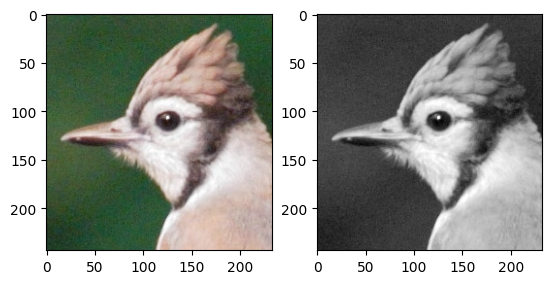

In [2]:
# Load image and conver to float representation
raw_img = cv2.imread("../dataset/sample_image.jpg")
raw_gray_img = cv2.cvtColor(raw_img, cv2.COLOR_BGR2GRAY)
img = raw_img.astype(np.float32) / 255.
gray_img = raw_gray_img.astype(np.float32) / 255.
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.imshow(gray_img, "gray")


### Results on Gray-scale Image

[[0.7622421 ]
 [0.28946057]]


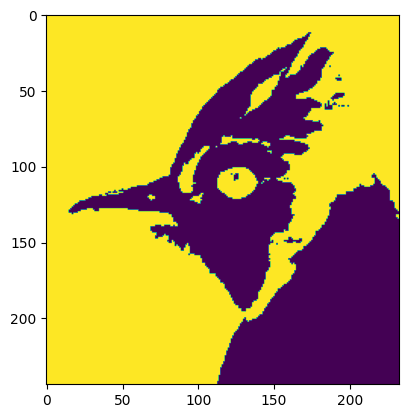

In [3]:
from sklearn.cluster import KMeans
# Flatten the image dimension first
gray_img_flat = gray_img.reshape(-1, 1)
kmeans = KMeans(n_clusters=2, random_state=0).fit(gray_img_flat)

H, W = gray_img.shape
# Unflatten back
labels = kmeans.labels_.reshape(H, W)
plt.imshow(labels)
print(kmeans.cluster_centers_)

[[0.8224684  0.7527633  0.7286135 ]
 [0.23835152 0.3262221  0.22156437]]


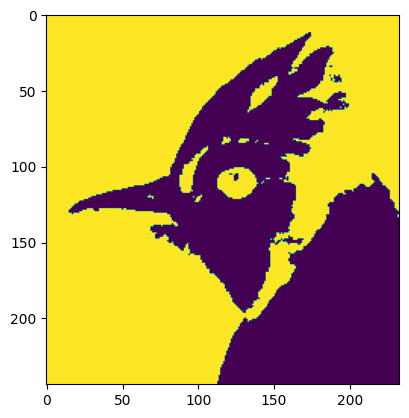

In [4]:
### Results on RGB image
img_flat = img.reshape(-1, 3)
kmeans = KMeans(n_clusters=2, random_state=0).fit(img_flat)

H, W, _ = img.shape
# Unflatten back
labels = kmeans.labels_.reshape(H, W)
plt.imshow(labels)
print(kmeans.cluster_centers_)

### Task 1.2 Implement your own k-means

Now you need to implement your own k-means function. Use your function on different greyscale images and try comparing the results to the results you get from sklearn kmeans function.

### Implement your own functions here:

In [5]:
def my_kmeans(I, k):
    """
    Parameters
    ----------
    I: the image to be segmented (greyscale to begin with) H by W array
    k: the number of clusters (use a simple image with k=2 to begin with)

    Returns
    ----------
    clusters: a vector that contains the final cluster centres
    L: an array the same size as the input image that contains the label for each of the image pixels, according to which cluster it belongs
    """

    assert len(I.shape) == 2, "Wrong input dimensions! Please make sure you are using a gray-scale image!"
    # Write your code here:
    # Flatten the image dimension first
    gray_img_flat = I.reshape(-1, 1)
    kmeans = KMeans(n_clusters=k, random_state=0).fit(gray_img_flat)
    clusters = kmeans.cluster_centers_

    H, W = I.shape
    # Unflatten back
    L = kmeans.labels_.reshape(H, W)
    
    return clusters, L 

def my_kmeans_rgb(I, k):
    """
    Parameters
    ----------
    I: the image to be segmented (greyscale to begin with) H by W array
    k: the number of clusters (use a simple image with k=2 to begin with)

    Returns
    ----------
    clusters: a vector that contains the final cluster centres
    L: an array the same size as the input image that contains the label for each of the image pixels, according to which cluster it belongs
    """

    assert len(I.shape) == 3, "Wrong input dimensions! Please make sure you are using a RGB image!"
    # Write your code here:
    img_flat = I.reshape(-1, 3)
    kmeans = KMeans(n_clusters=k, random_state=0).fit(img_flat)
    clusters = kmeans.cluster_centers_

    H, W, _ = I.shape
    # Unflatten back
    L = kmeans.labels_.reshape(H, W)
    
    return clusters, L 



### Show results here:

[[0.7622421 ]
 [0.28946057]]


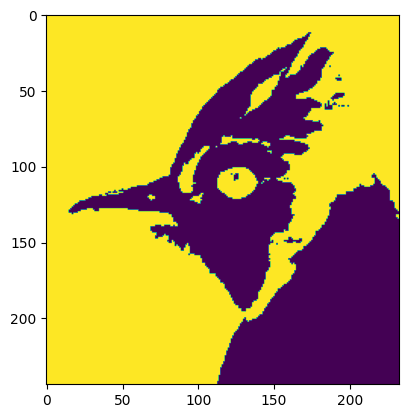

In [6]:
centroids, labels = my_kmeans(gray_img, 2)
print(centroids)
plt.imshow(labels)

### More things to try out:
1. Try different values for k. For k > 2 you will need some way to display the output L (other than simple black and white). Consider using a colour map with the imshow function.
2. Adapt your function so that it will handle colour dataset as well. What changes do you have to make?

[[0.64946234]
 [0.2819037 ]
 [0.83989084]]


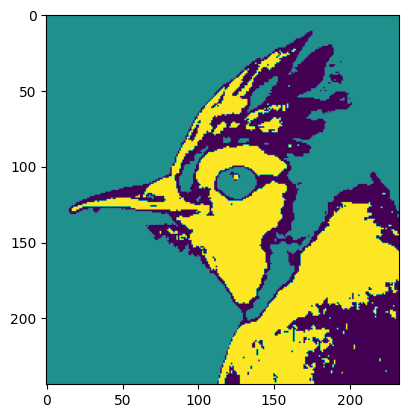

In [7]:
# k=3
centroids, labels = my_kmeans(gray_img, 3)
plt.imshow(labels)
print(centroids)

[[205.24595207 182.24133744 173.62427137]
 [ 54.03994115  80.90118008  52.17353742]
 [138.29347015 116.69552239 108.61511194]
 [230.49895732 223.68219102 222.5751425 ]]


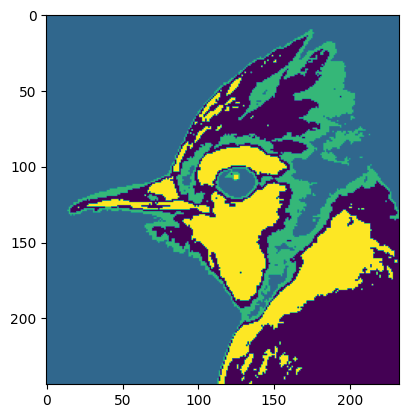

In [ ]:
centroids, labels = my_kmeans_rgb(img, 2)
plt.imshow(labels)
print(centroids)

In [9]:
# to visualize the plots within the notebook
%matplotlib inline
# to enable interactive
#%matplotlib ipympl
import matplotlib.image as mpimg
from matplotlib import pyplot as plt
import random
from PIL import Image

## Task 2: Region growing
Region growing is a simple way to segment a region of interest from the background of an image.
It takes in a gray-scale image and produces a binary image as output, where a value of 1 represents the region of interest and a value of 0 represents the background.

The algorithm is:
1. Start from a seed pixel.
2. Add neighbouring pixels that satisfy the criteria defining a region (e.g. similar intensity values, intensity above a threshold).
3. Repeat until we can include no more pixels.

Your task is to write a function in Python that implements the region growing algorithm.
Something like:
```
  segmented_img = region_growing(img, x, y)
```

* img: the image to be segmented
* x: the x-coordinate (j if indexed by numpy array) of the seed pixel
* y: the y-coordinate (i if indexed by numpy array) of the seed pixel
* segmented_img: the binary image output of region growing

**Hint:** This is process basically a **Breadth-first Search (BFS)**, which could be easily implemented it with a **queue** (check out collections.deque in PyThon): 

1. Initialise the queue with the seed pixel. 
2. Every time pop the first element from the queue and add its neighbour pixels to the queue if they satisfy the criteria (e.g. intensity above the threshold).
3. Finish when the queue is empty

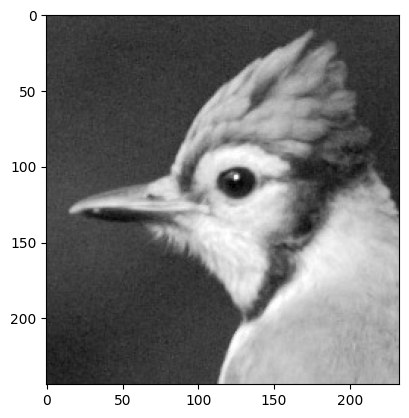

In [10]:
# Load your image
img = cv2.imread('../dataset/sample_image.jpg')
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(np.float32)
plt.imshow(gray_img, 'gray')
plt.show()

In [51]:
from collections import deque
def region_growing(img, x, y, thresh=100, connectedness=4):
    '''
    Impelemnt region growing algorithm to segment a gray scaled image into regions
    :param img: gray scaled image [H, W]
    :param x, y: coordinate of the seed pixel
    :param thresh: region growing threshold
    :return: segmented image [H, W]
    '''
    assert img.ndim == 2, "Expect a gray-scale image!!!"
    # Write your own code here

    # Get image dimensions
    H, W = img.shape

    # Create an output segmented image initialized to zeros
    segmented = np.zeros((H, W), dtype=np.uint8)

    # Seed pixel intensity value
    seed_value = img[x, y]

    # Create a deque for BFS
    queue = deque()
    queue.append((x, y))


    # Set of directions for connectedness
    if connectedness == 4:
        directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]  # Up, Down, Left, Right

    elif connectedness == 8:
        directions = [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (-1, 1), (1, -1), (1, 1)]  # 8-connected

    else:
        raise ValueError("Connectedness must be 4 or 8")
    
    # Start region growing
    while queue:
        cx, cy = queue.popleft()

        # Skip if this pixel is already segmented
        if segmented[cx, cy] == 1:
            continue

        # Mark the pixel as part of the region
        segmented[cx, cy] = 1

        # Check neighbors
        for dx, dy in directions:
            nx, ny = cx + dx, cy + dy

            # Ensure the neighbor is within bounds and not already segmented
            if 0 <= nx < H and 0 <= ny < W and segmented[nx, ny] == 0:
                # Add neighbor to the queue if it satisfies the threshold condition
                if abs(int(img[nx, ny]) - int(seed_value)) <= thresh:
                    queue.append((nx, ny))

    return segmented


    

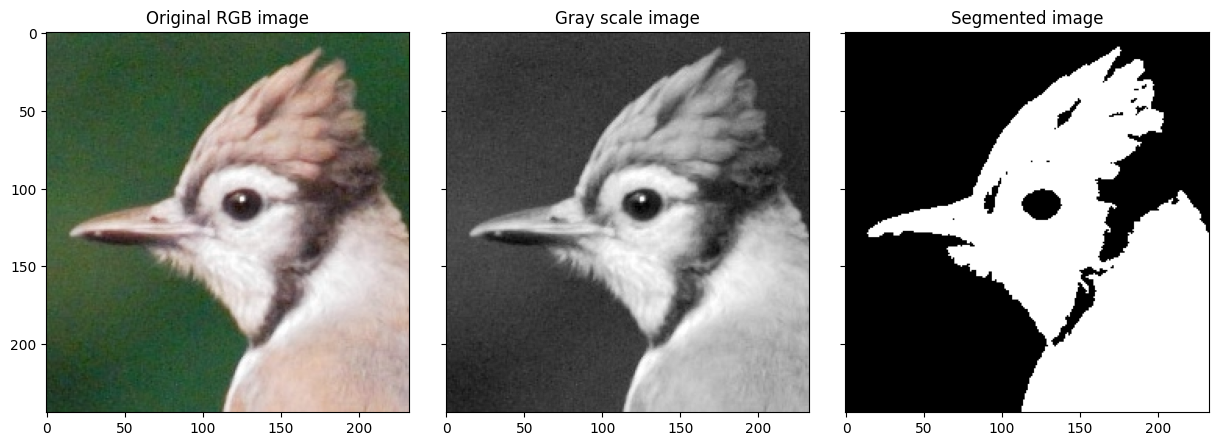

In [62]:
# define set of seed pixel points
x, y = 100, 100

# run region growing algorithm
seg_img = region_growing(gray_img, x, y, thresh=80, connectedness=4)

# Show Original and segmented image
fig, axis = plt.subplots(1, 3, figsize=(15,10), sharey=True)
fig.subplots_adjust(wspace=0.1, hspace=0.05)
axis[0].imshow(img)
axis[0].set_title('Original RGB image')

axis[1].imshow(gray_img, 'gray')
axis[1].set_title('Gray scale image')

axis[2].imshow(seg_img, 'gray')
axis[2].set_title('Segmented image')
plt.show()

### There are two important factors that influence the performance of a region growing algorithm.

#### 1. The first is the seed pixel selection.
Try the following:
1. Pick a random pixel in the image.
2. Plot the histogram of the image, select a reasonable threshold and then search for a pixel whose intensity value is above the threshold (look for the `matplotlib.pyplot.hist()` function).
3. Do it manually (Hint: You can do this by enabling the interactive mode for `matplotlib`).

Which one is better?

(array([[  0.,  51., 181., ...,   0.,   0.,   0.],
        [  1.,  44., 187., ...,   0.,   0.,   0.],
        [  0.,  46., 183., ...,   0.,   0.,   0.],
        ...,
        [  0.,  74.,  50., ...,  56.,   0.,   0.],
        [  0.,  74.,  53., ...,  41.,   0.,   0.],
        [  0.,  86.,  43., ...,  38.,   0.,   0.]]),
 array([ 16.        ,  39.90000153,  63.79999924,  87.69999695,
        111.59999847, 135.5       , 159.3999939 , 183.30000305,
        207.19999695, 231.09999084, 255.        ]),
 <a list of 233 BarContainer objects>)

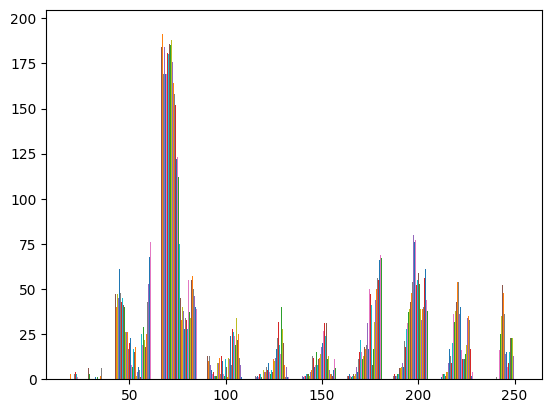

In [65]:
plt.hist(gray_img)

In [66]:
import matplotlib
# Turn on interactive mode
matplotlib.use('Agg')
# pick three points
%matplotlib tk  
plt.imshow(gray_img, 'gray')
x = plt.ginput(3) 
print(x)



[(np.float64(92.23376623376626), np.float64(132.59090909090907)), (np.float64(163.53246753246756), np.float64(76.6082251082251)), (np.float64(158.2510822510823), np.float64(164.8073593073593))]


In [67]:
%matplotlib inline 
#  go back to inline plot

#### 2. The second important factor is how to decide whether to add a neighbouring pixel to the existing region. 

Again, there are different options. Try the following alternatives:

1. Compare the pixel intensity value of the neighbours to a specified threshold (try the pixel intensity value of the initial seed pixel). If it is larger, then add it to the region. Depending on the seed pixel you might consider adding pixels with smaller intensities or even using a range of valid intensity values.
    
2. Compare the pixel intensity value of the neighbours to the average pixel intensity value of the existing region. The neighbour with the smallest difference to the average is added to the region. How will we stop adding neighbours to the region in this case?

Which one is better?

In [52]:
# Write your own code here
from collections import deque

def region_growing_avg(img, x, y, dist_thresh=50, connectedness=4):
    '''
    Implement region growing algorithm to segment a gray-scaled image into regions, using region average.
    :param img: gray-scaled image [H, W]
    :param x, y: coordinate of the seed pixel
    :param thresh: region growing threshold
    :param connectedness: 4 or 8 for connected neighbors
    :return: segmented image [H, W]
    '''
    assert img.ndim == 2, "Expect a gray-scale image!!!"

    # Get image dimensions
    H, W = img.shape

    # Create an output segmented image initialized to zeros
    segmented = np.zeros((H, W), dtype=np.uint8)

    # Initialize region statistics
    region_sum = img[x, y]  # Sum of pixel intensities in the region
    region_count = 1  # Number of pixels in the region
    region_avg = region_sum / region_count  # Initial average intensity

    # Create a deque for BFS
    queue = deque()
    queue.append((x, y))

    # Set of directions for connectedness
    if connectedness == 4:
        directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]  # Up, Down, Left, Right

    elif connectedness == 8:
        directions = [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (-1, 1), (1, -1), (1, 1)]  # 8-connected
    
    else:
        raise ValueError("Connectedness must be 4 or 8")

    # Start region growing
    while queue:
        cx, cy = queue.popleft()

        # Skip if this pixel is already segmented
        if segmented[cx, cy] == 1:
            continue

        # Mark the pixel as part of the region
        segmented[cx, cy] = 1

        # Update region statistics
        region_sum += img[cx, cy]
        region_count += 1
        region_avg = region_sum / region_count

        # Check neighbors
        for dx, dy in directions:
            nx, ny = cx + dx, cy + dy

            # Ensure the neighbor is within bounds and not already segmented
            if 0 <= nx < H and 0 <= ny < W and segmented[nx, ny] == 0:
                # Add neighbor to the queue if it satisfies the threshold condition
                if abs(int(img[nx, ny]) - region_avg) <= dist_thresh:
                    queue.append((nx, ny))

    return segmented


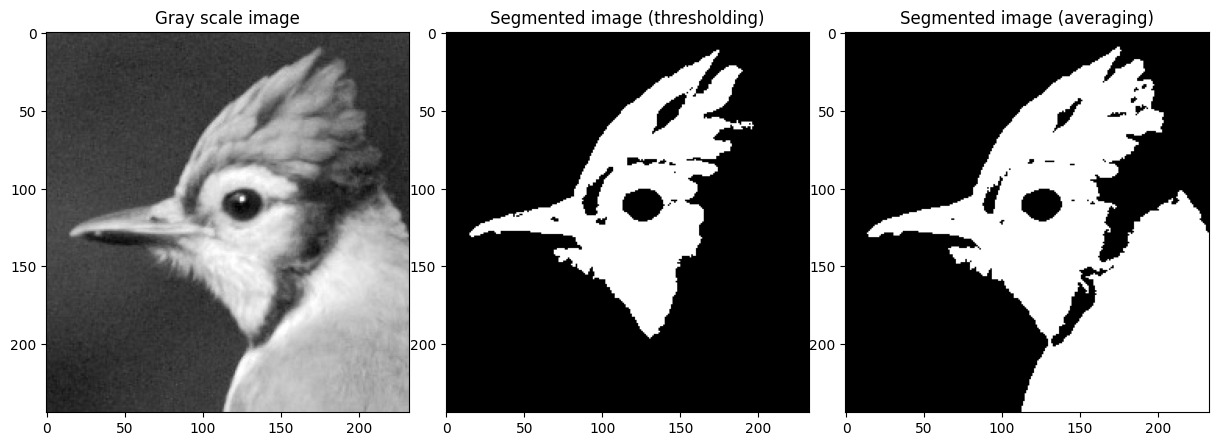

In [96]:
# define set of seed pixel points
x, y = 140, 140

# run region growing algorithm
seg_img = region_growing(gray_img, x, y, thresh=90, connectedness=4)
seg_img2 = region_growing_avg(gray_img, x, y, dist_thresh=90, connectedness=4)

# Show Original and segmented image
fig, axis = plt.subplots(1, 3, figsize=(15,15))
fig.subplots_adjust(wspace=0.1, hspace=0.05)
# axis[0].imshow(img)
# axis[0].set_title('Original RGB image')

axis[0].imshow(gray_img, 'gray')
axis[0].set_title('Gray scale image')

axis[1].imshow(seg_img, 'gray')
axis[1].set_title('Segmented image (thresholding)')

axis[2].imshow(seg_img2, 'gray')
axis[2].set_title('Segmented image (averaging)')
plt.show()

### More things to try out:
1. What kind of connectivity did you use for considering neighbour pixels? If you used 4- connectivity, try 8-connectivity, if you used 8-connectivity then try 4-connectivity.
    Does this change results?
    
2. What if there are multiple regions of interest? Consider using multiple seed points. How will you choose these?

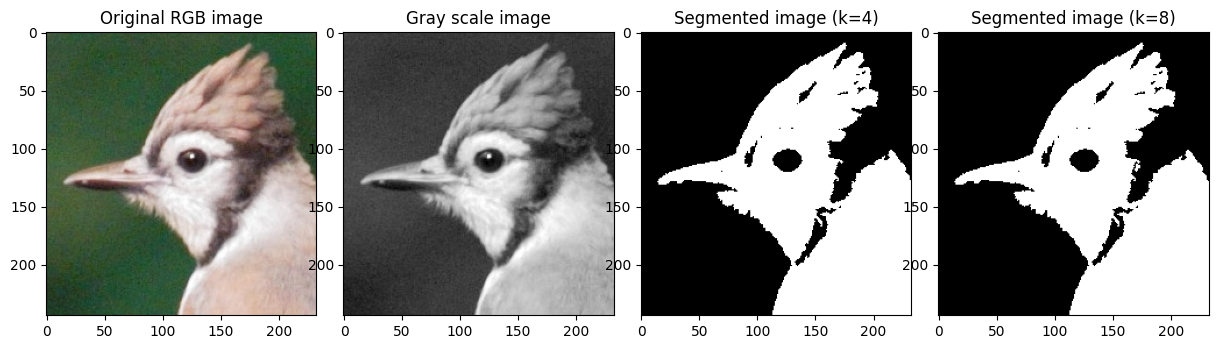

In [94]:
# define set of seed pixel points
x, y = 100, 100

# run region growing algorithm
seg_img = region_growing(gray_img, x, y, thresh=80, connectedness=4)
seg_img2 = region_growing(gray_img, x, y, thresh=80, connectedness=8)

# Show Original and segmented image
fig, axis = plt.subplots(1, 4, figsize=(15,15))
fig.subplots_adjust(wspace=0.1, hspace=0.05)
axis[0].imshow(img)
axis[0].set_title('Original RGB image')

axis[1].imshow(gray_img, 'gray')
axis[1].set_title('Gray scale image')

axis[2].imshow(seg_img, 'gray')
axis[2].set_title('Segmented image (k=4)')

axis[3].imshow(seg_img2, 'gray')
axis[3].set_title('Segmented image (k=8)')
plt.show()

## Task 3: Connected Components 

Connected-component labeling (also known as connected-component analysis, or region labeling) is an algorithmic application of graph theory that is used to determine the connectivity of “blob”-like regions in a binary image.
Specifically, the algorithm labels each connected component of a binary image with a separate number.

Similar to Region Growing, for a single connected-component we can start from a seed and iteratively traverse all the neighbouring pixels. In this case, a Depth-first Serach (DFS) is a better way:

Then we just need to repeat this process for all the connected components in the image.

In [105]:
def connected_components_label(img, connectedness=4):
    # Write your own code here

    assert img.ndim == 2, "Input must be a 2D binary image!"

    # Get image dimensions
    H, W = img.shape

    # Create an output labeled image initialized to zeros
    labeled_image = np.zeros_like(img, dtype=int)

    # Initialize label counter
    current_label = 1
    visited = np.zeros_like(img, dtype=bool)

    # Set of directions for connectedness
    if connectedness == 4:
        directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]  # Up, Down, Left, Right
    
    elif connectedness == 8:
        directions = [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (-1, 1), (1, -1), (1, 1)]  # 8-connected

    else:
        raise ValueError("Connectedness must be 4 or 8")
    
     # Iterate through each pixel in the binary image
    for y in range(H):
        for x in range(W):
            # If the pixel is part of a component and not yet labeled
            if img[y,x] == 0 or visited[y,x]:
                continue

            stack = [(x,y)]
            visited[y,x] = True
                
            # Perform BFS to label the component
            while stack:
                cx, cy = stack.pop()
                # Label the pixel
                labeled_image[cy, cx] = current_label
                    
                # Check all neighbors
                for dx, dy in directions:
                    nx, ny = cx + dx, cy + dy
    
                    # Ensure the neighbor is within bounds and part of the component
                    if 0 <= nx < W and 0 <= ny < H and not visited[ny,nx]:
                        if img[ny,nx] == 1:
                            stack.append((nx, ny))
                            visited[ny,nx] = True

            current_label += 1

    total_labels = current_label
    return labeled_image
    




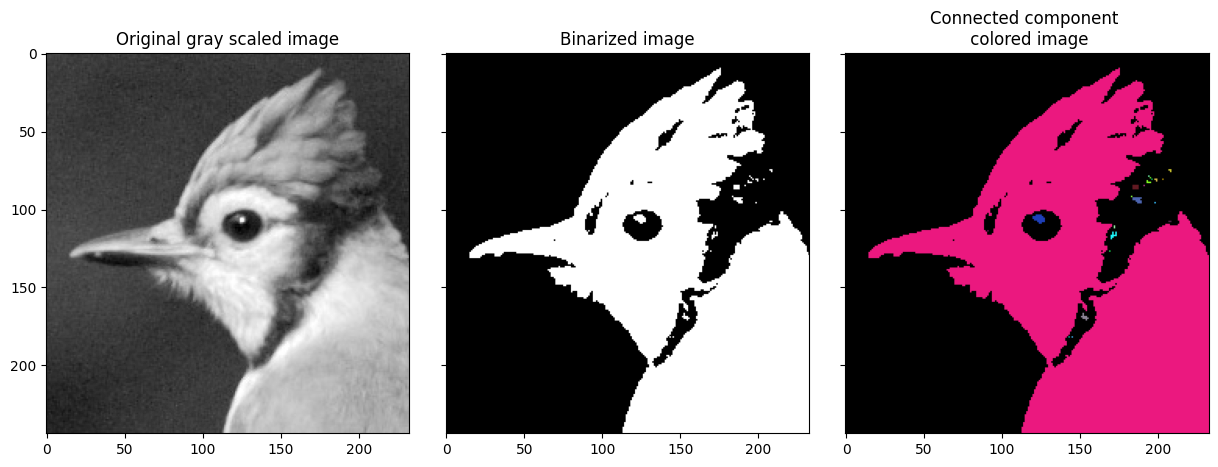

In [106]:
from utils import colourize

bimg = (gray_img > 100).astype(np.float32)
ccl_img = connected_components_label(bimg)

fig, axis = plt.subplots(1, 3, figsize=(15,10), sharey=True)
fig.subplots_adjust(wspace=0.1, hspace=0.05)
axis[0].imshow(gray_img, 'gray')
axis[0].set_title('Original gray scaled image')

axis[1].imshow(bimg, 'gray')
axis[1].set_title('Binarized image')

axis[2].imshow(colourize(ccl_img))
axis[2].set_title('Connected component \n colored image')
plt.show()



The previous image was not a very good example to showcase the connected component algorithm. Next, you will see a better image.

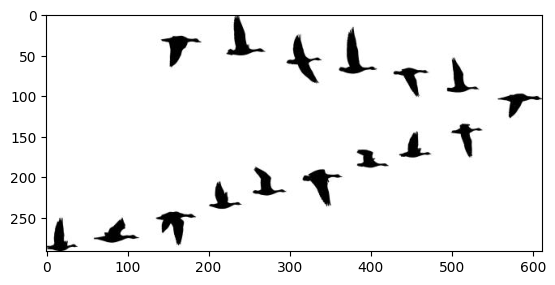

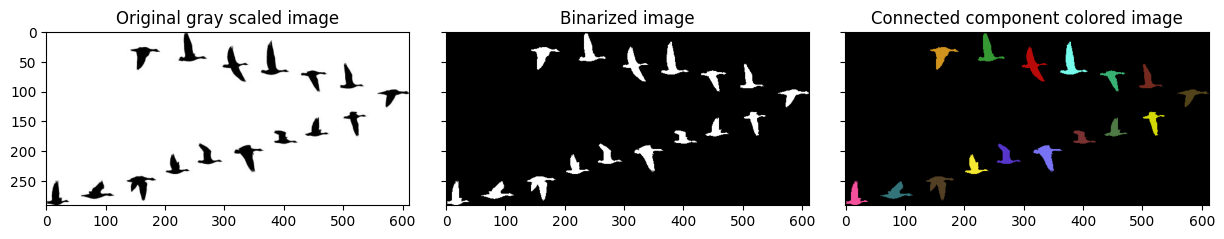

In [107]:
img2 = cv2.imread("../dataset/gooses.jpg")
gray_img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY).astype(np.float32)
plt.imshow(gray_img2, 'gray')

bimg2 = (gray_img2 < 100).astype(np.float32)
ccl_img2 = connected_components_label(bimg2)

fig, axis = plt.subplots(1, 3, figsize=(15,10), sharey=True)
fig.subplots_adjust(wspace=0.1, hspace=0.05)
axis[0].imshow(gray_img2, 'gray')
axis[0].set_title('Original gray scaled image')

axis[1].imshow(bimg2, 'gray')
axis[1].set_title('Binarized image')

axis[2].imshow(colourize(ccl_img2))
axis[2].set_title('Connected component colored image')
plt.show()


### Tasks
Your task is to count the number of candies in the image below (Candy1):
1. Show your code and intermediate results for each step
2. Explain how the parameters were selected and what prior information you use.
3. Report your answer
4. Try your code on Candy2 without anychanges and report reuslt, discuss how would you improve the method for them.

In [108]:
def count_candies(ccl_img, min_size):
    """
    Count the number of candies by filtering small connected components.
    :param ccl_img: Labeled connected components image
    :param min_size: Minimum size of a connected component to be considered
    :return: Number of candies
    """
    unique_labels, counts = np.unique(ccl_img, return_counts=True)
    valid_components = [label for label, count in zip(unique_labels, counts) if count >= min_size and label != 0]
    return len(valid_components)

There are 19 different candies in image 1


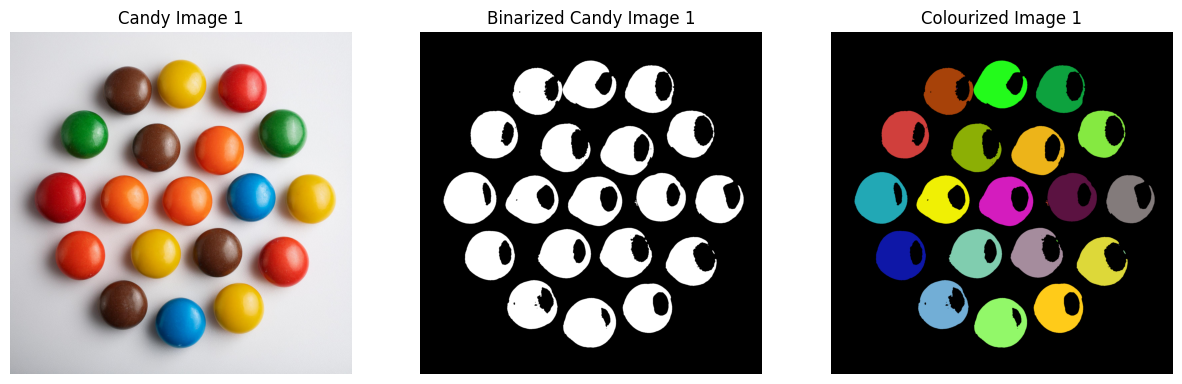

In [126]:
# Read first candy image
img1 = cv2.imread('../dataset/candy1.jpeg')
# Convert BGR to RGB for correct color display
img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)


# Increase the intensity of image 1
img1_ = cv2.convertScaleAbs(img1, alpha=3, beta=60)

# Convert to gray scale
gray_img1 = cv2.cvtColor(img1_, cv2.COLOR_BGR2GRAY).astype(np.float32)

#Apply gaussian blur
gray_img1 = cv2.GaussianBlur(gray_img1, (13, 13), 0)

# Binary image
bimg1 = ((gray_img1 > 0) & (gray_img1 < 250)).astype(np.float32)


# Connected Components
ccl_img1 = connected_components_label(bimg1,connectedness=8)

num_candies = count_candies(ccl_img1,min_size=200)

print(f"There are {num_candies} different candies in image 1")

# Create figure with two subplots side by side
plt.figure(figsize=(15, 5))

# Display first image
plt.subplot(1, 3, 1)
plt.imshow(img1_rgb)
plt.title('Candy Image 1')
plt.axis('off')

# Display Binarized Image 1
plt.subplot(1,3,2)
plt.imshow(bimg1,"gray")
plt.title("Binarized Candy Image 1")
plt.axis('off')

# Display Colored Image 1
plt.subplot(1,3,3)
plt.imshow(colourize(ccl_img1))
plt.title("Colourized Image 1")
plt.axis('off')

plt.show()


There are 8 different candies in image 2


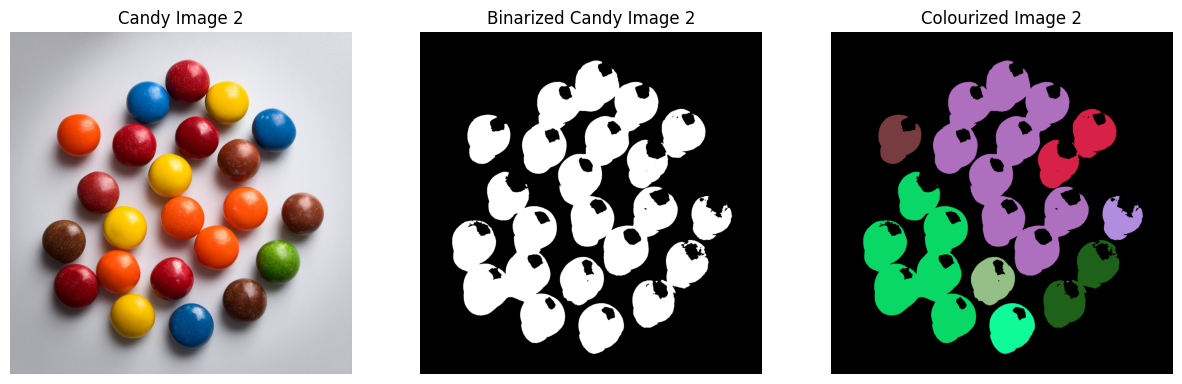

In [136]:
# Read second candy image
img2 = cv2.imread('../dataset/candy2.jpeg')
# Convert BGR to RGB for correct color display
img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

# Increase the intensity of image 1
img2_ = cv2.convertScaleAbs(img2, alpha=3, beta=60)

# Convert to gray scale
gray_img2 = cv2.cvtColor(img2_, cv2.COLOR_BGR2GRAY).astype(np.float32)

#Apply gaussian blur
gray_img2 = cv2.GaussianBlur(gray_img2, (13, 13), 0)


# Binary image
bimg2 = ((gray_img2 > 0) & (gray_img2 < 250)).astype(np.float32)

# Connected Components
ccl_img2 = connected_components_label(bimg2,connectedness=8)

num_candies2 = count_candies(ccl_img2,min_size=200)

print(f"There are {num_candies2} different candies in image 2")

# Create figure with three subplots side by side
plt.figure(figsize=(15, 5))

# Display second image
plt.subplot(1, 3, 1)
plt.imshow(img2_rgb)
plt.title('Candy Image 2')
plt.axis('off')

# Display Binarized Image 2
plt.subplot(1,3,2)
plt.imshow(bimg2,"gray")
plt.title("Binarized Candy Image 2")
plt.axis('off')

# Display Colored Image 2
plt.subplot(1,3,3)
plt.imshow(colourize(ccl_img2))
plt.title("Colourized Image 2")
plt.axis('off')

plt.show()

# Part 2: Filter
In the last lecture you learned about linear image filtering operations like correlation and
convolution and how these can be applied directly on the image.
These kind of filtering operations have many uses, ranging from smoothing and noise
reduction, to feature enhancement and sharpening, calculating image derivatives, edge
detection and even template matching.
Your task today is to code your own linear filtering functions operating on the image domain.

In [ ]:
import numpy as np
import cv2
import matplotlib.image as mpimg
from matplotlib import pyplot as plt
# to visualize the plots within the notebook
%matplotlib inline

## Task 4 Convolution
Convolution is a fundamental operation for applying linear filters to images. It takes as input
an image (greyscale) I and a filter kernel K and returns the result I’ of convolving the image
with this filter.

Definition: Given a greyscale image I and a filter K of size (2N + 1) x (2M + 1) (we use odd
dimension filters like 3 x 3, 5 x 5 etc.), convolution is defined as:

\begin{equation}
I'(x, y) = \sum_{i=-a}^a \sum_{j=-b}^b K(i, j) I(x - i, y - j)
\end{equation}

Your task is to write your own convolution function (do not use the conv2() function) and test
it with different filters. How will you handle the behaviour of the filter in the edges of the
image (pad with zeros, copy the edge etc.)?

Smoothing filters that reduce noise in images are quite useful in image processing. Use a
simple mean filter like:

\begin{equation}
\begin{bmatrix}1 & 1 & 1\\1 & 1 & 1\\1 & 1 & 1\end{bmatrix}
\end{equation}

This filter replaces each pixel by the average of its neighbourhood. Now if we want
something better, we can try weighing the contributions of the neighbouring pixels by their
proximity to the centre pixel. Try a Gaussian filter, which is defined as: 

\begin{equation}
G_{\sigma} = \frac{1}{2\pi \sigma^2} e^{-\frac{(x^2 + y^2)}{2 \sigma^2}}
\end{equation}

where $\sigma$ is the standard deviationof the Gaussian. This is a continuous function, so your filter will need to sample it in both x and y directions (use np.meshgrid()), keeping in mind the value for $\sigma$ that you chose. Try different filter sizes and different values for $\sigma$ and compare the results. Here is the results obtained using opencv built-in functions. If your implementation is correct, you should expect to have similar results.

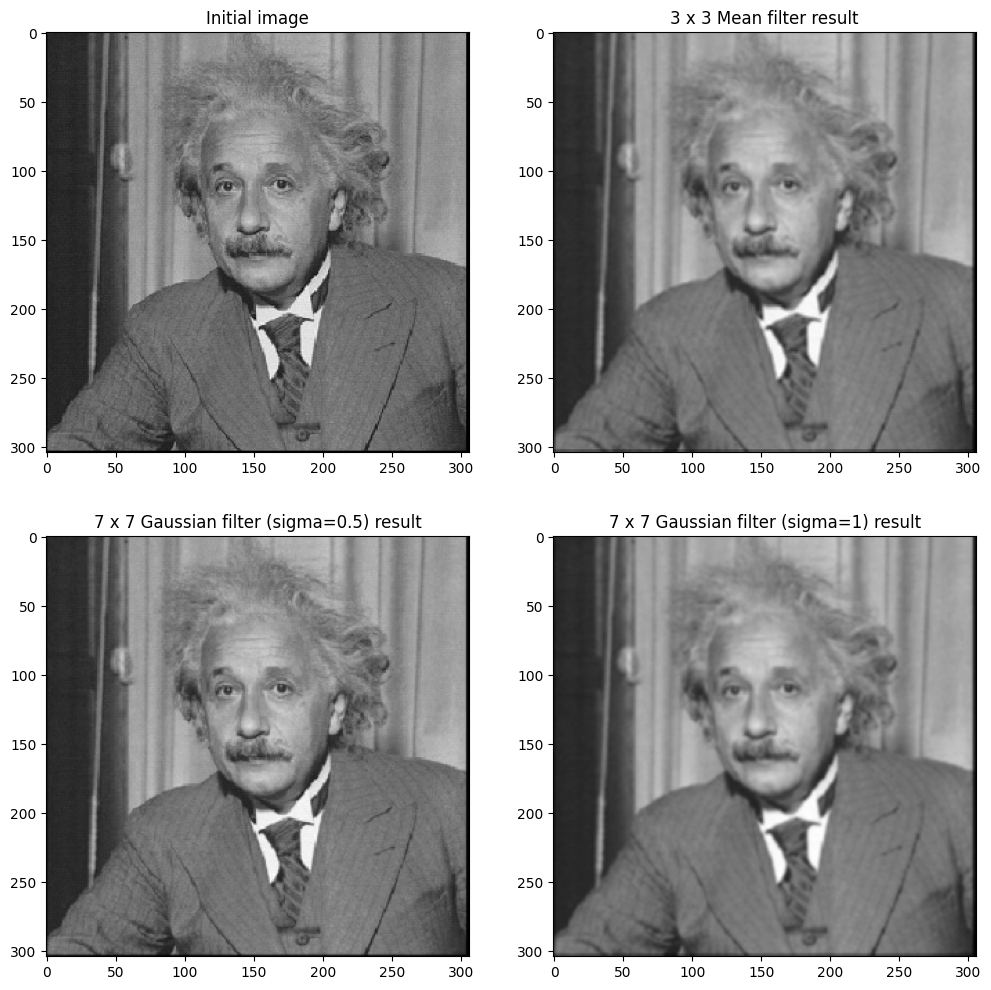

In [ ]:
img = cv2.imread("../dataset/einstein.png")
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(np.float32)
mean_blur = cv2.blur(img_gray, (3, 3))  # mean filter 3x3
gaussian_1 = cv2.GaussianBlur(img_gray, (7, 7), 0.5, 0.5)  # gaussian filter 7x7, sigma = 0.5
gaussian_2 = cv2.GaussianBlur(img_gray, (7, 7), 1., 1.)  # gaussian filter 7x7, sigma = 1.0
fig = plt.figure(figsize=(12, 12))
ax1 = plt.subplot(2, 2, 1)
ax1.title.set_text("Initial image")
plt.imshow(img_gray, "gray")
ax2 = plt.subplot(2, 2, 2)
ax2.title.set_text("3 x 3 Mean filter result")
plt.imshow(mean_blur, "gray")
ax3 = plt.subplot(2, 2, 3)
ax3.title.set_text("7 x 7 Gaussian filter (sigma=0.5) result")
plt.imshow(gaussian_1, "gray")
ax4 = plt.subplot(2, 2, 4)
ax4.title.set_text("7 x 7 Gaussian filter (sigma=1) result")
plt.imshow(gaussian_2, "gray")
plt.show()

### Implement your own code here:

hint: You can use `cv2.copyMakeBorder` to do paddings to the image. Figure out how to use it by yourself!

In [ ]:
"""
Implement your code here
"""
def apply_filter(src_img, kernel):
    '''
    Impelemnt filtering algorithm
    :param src_img: gray scaled source image with size HxW
    :param kernel: kernel to be applied to the source image
    :return rst_img: filtered image
    '''
    assert len(src_img.shape) == 2, print("Dimension mismatch! Please supply gray-scale image only!")
    assert len(kernel.shape) == 2, print("Dimension mismatch! Please supply 2D kernel only!")

    H, W = src_img.shape
    kH, kW = kernel.shape

    pad_h = kH // 2
    pad_w = kW // 2

        # Pad the source image with zeros (constant border)
    padded_img = np.pad(src_img, ((pad_h, pad_h), (pad_w, pad_w)), mode='constant', constant_values=0)

    # Initialize the result image
    rst_img = np.zeros_like(src_img, dtype=np.float32)

    # Perform convolution
    for i in range(H):
        for j in range(W):
            # Extract the current region of interest
            roi = padded_img[i:i + kH, j:j + kW]

            # Compute the convolution: element-wise multiplication and sum
            rst_img[i, j] = np.sum(roi * kernel)

    return rst_img

    
def get_mean_filter_kernel(h, w):
    '''
    Get kernel of mean filter
    '''
    return np.ones((h, w)) / (h * w)

def get_gaussian_kernel(h, w, sigma):
    '''
    Get kernel of Gaussian filter
    '''
    assert (h % 2 == 1) and (w % 2 == 1), print("kernal size must be odd number!")

    x = np.arange(-(h // 2), h // 2 + 1, 1.)
    y = np.arange(-(w // 2), w // 2 + 1, 1.)
    xx, yy = np.meshgrid(x, y)
    two_sigma_2 = 2 * sigma ** 2
    G = np.exp(-(xx ** 2 + yy ** 2) / two_sigma_2) / (two_sigma_2 * np.pi)
    G /= G.sum()
    return G

    

In [ ]:
"""
Get kernels and apply filter here
"""
k_mean = get_mean_filter_kernel(3, 3)
G1 = get_gaussian_kernel(7, 7, 0.5)
G2 = get_gaussian_kernel(7, 7, 1.)
img_mean_blur = apply_filter(img_gray, k_mean)
img_gaussian_1 = apply_filter(img_gray, G1)
img_gaussian_2 = apply_filter(img_gray, G2)


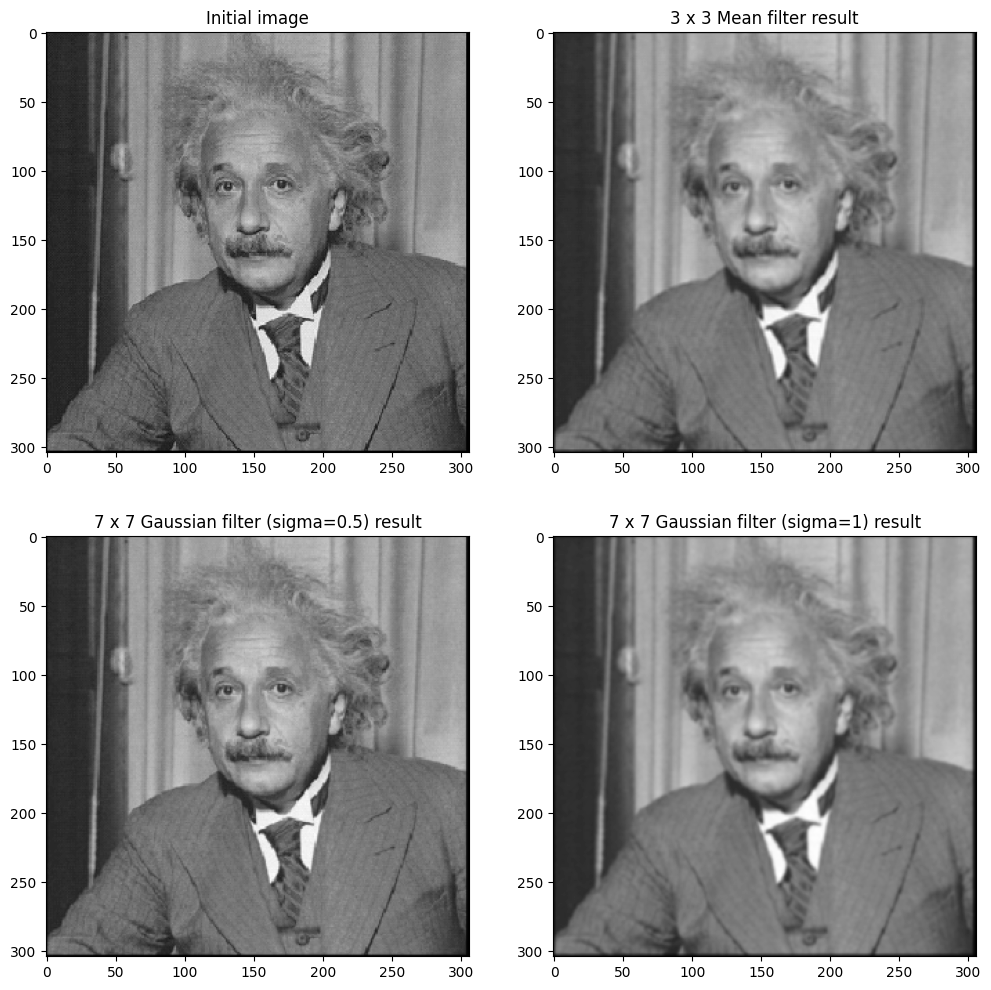

In [ ]:

"""
Plot the results
"""
fig = plt.figure(figsize=(12, 12))
ax1 = plt.subplot(2, 2, 1)
ax1.title.set_text("Initial image")
plt.imshow(img_gray, "gray")
ax2 = plt.subplot(2, 2, 2)
ax2.title.set_text("3 x 3 Mean filter result")
plt.imshow(img_mean_blur, "gray")
ax3 = plt.subplot(2, 2, 3)
ax3.title.set_text("7 x 7 Gaussian filter (sigma=0.5) result")
plt.imshow(img_gaussian_1, "gray")
ax4 = plt.subplot(2, 2, 4)
ax4.title.set_text("7 x 7 Gaussian filter (sigma=1) result")
plt.imshow(img_gaussian_2, "gray")
plt.show()

## Task 5: Edge Detection with Sobel Filter
The Sobel filter is commonly used to detect edges in images by calculating the gradient of the image intensity. It emphasizes areas of high spatial frequency that correspond to edges. Here, we will apply the Sobel filter to detect edges in the grayscale image of Albert Einstein.

We start by applying separate Sobel filters in both the x and y directions, which will highlight horizontal and vertical edges, respectively. The combined result will provide a comprehensive edge map of the entire image.



### Tasks:
* Use your own kenel and extract edge on x and y with sobel filter with only numpy.
* Using the package - *time* does your algorithm compare to the built-in median filtering of opencv? Also, measure the time difference and compare result from your implementation and opencv

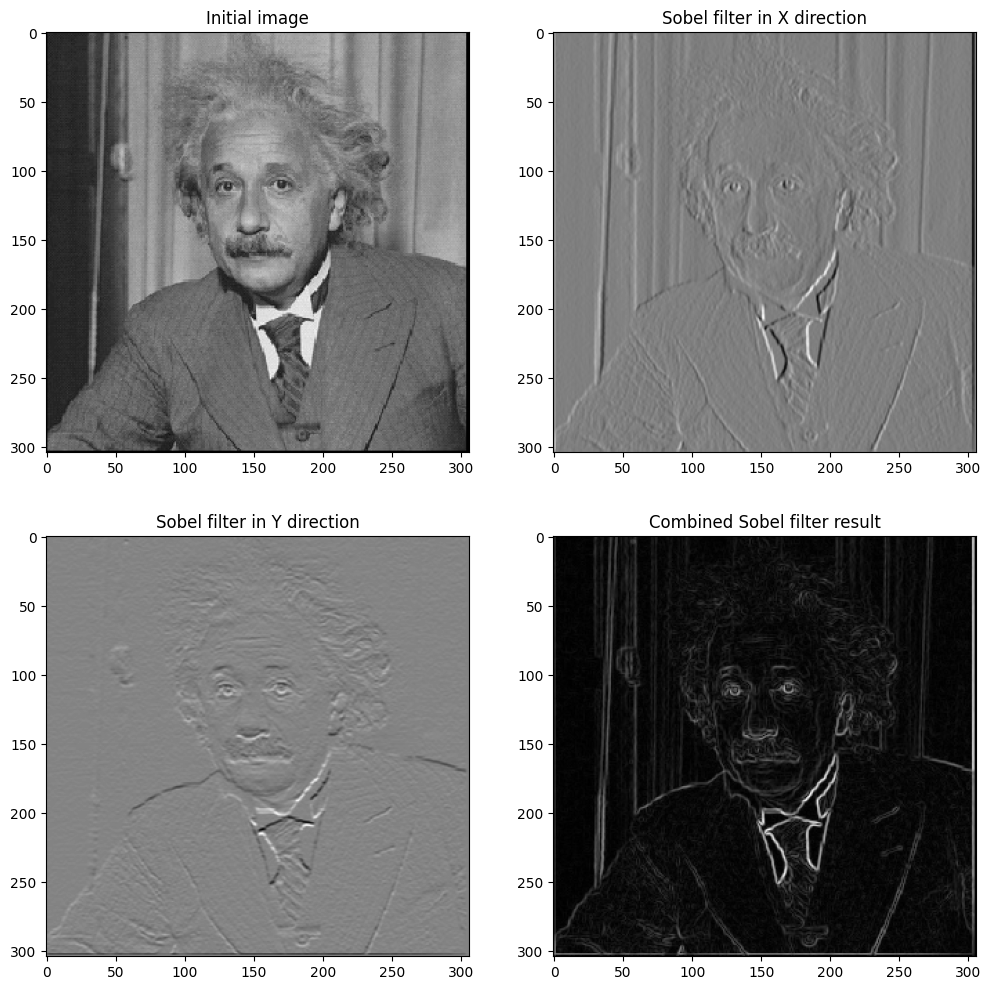

In [ ]:
img = cv2.imread("../dataset/einstein.png")
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(np.float32)
sobel_x = cv2.Sobel(img_gray, cv2.CV_64F, 1, 0, ksize=3)  # Sobel filter in x direction
sobel_y = cv2.Sobel(img_gray, cv2.CV_64F, 0, 1, ksize=3)  # Sobel filter in y direction
sobel_combined = cv2.magnitude(sobel_x, sobel_y)  # Combine the gradients
fig = plt.figure(figsize=(12, 12))
ax1 = plt.subplot(2, 2, 1)
ax1.title.set_text("Initial image")
plt.imshow(img_gray, "gray")
ax2 = plt.subplot(2, 2, 2)
ax2.title.set_text("Sobel filter in X direction")
plt.imshow(sobel_x, "gray")
ax3 = plt.subplot(2, 2, 3)
ax3.title.set_text("Sobel filter in Y direction")
plt.imshow(sobel_y, "gray")
ax4 = plt.subplot(2, 2, 4)
ax4.title.set_text("Combined Sobel filter result")
plt.imshow(sobel_combined, "gray")
plt.show()


In [46]:

def sobel_filter(src_img,dx,dy,ksize=3):
    '''
    Apply Sobel filter with specified kernel size and direction.
    :param src_img: Gray-scale input image (2D array).
    :param dx: Order of the derivative in the x-direction (0 or 1).
    :param dy: Order of the derivative in the y-direction (0 or 1).
    :param ksize: Kernel size (must be an odd number, e.g., 3, 5).
    :return: Filtered image (rst_img) showing the gradient magnitude.
    '''
    assert len(src_img.shape) == 2, "Input must be a gray-scale image!"

    if ksize != 3:
        raise ValueError("Only kernel size 3 is supported")
    
    rst_img = np.zeros_like(src_img)
    H,W = src_img.shape

    sobel_x_filter = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype = np.float32) # Sobel filter in x direction
    sobel_y_filter = np.array([[-1, -2, -1],[ 0,  0,  0],[ 1,  2,  1]], dtype=np.float32) # Sobel filter in y direction
    top, bottom = ksize // 2 , ksize // 2
    left, right = ksize // 2 , ksize // 2
    padded_img = cv2.copyMakeBorder(img_gray, top, bottom, left, right, cv2.BORDER_REFLECT) # Reflect padding for border

    if dx == 1 and dy == 0: 
        kernel = sobel_x_filter
        for i in range(H):
            for j in range(W):
                rst_img[i, j] = np.sum(padded_img[i:i+ksize, j:j+ksize] * kernel)

    elif dx == 0 and dy == 1:
        kernel = sobel_y_filter
        for i in range(H):
            for j in range(W):
                rst_img[i, j] = np.sum(padded_img[i:i+ksize, j:j+ksize] * kernel)

        
    else: # Apply Sobel-X and Sobel-Y filters
        grad_x = apply_filter(src_img, sobel_x_filter)
        grad_y = apply_filter(src_img, sobel_y_filter)

        # Compute gradient magnitude
        gradient_magnitude = np.sqrt(grad_x**2 + grad_y**2)
        # Normalize gradient to range [0, 255] for display as an image
        rst_img = (gradient_magnitude / gradient_magnitude.max()) * 255




    return rst_img


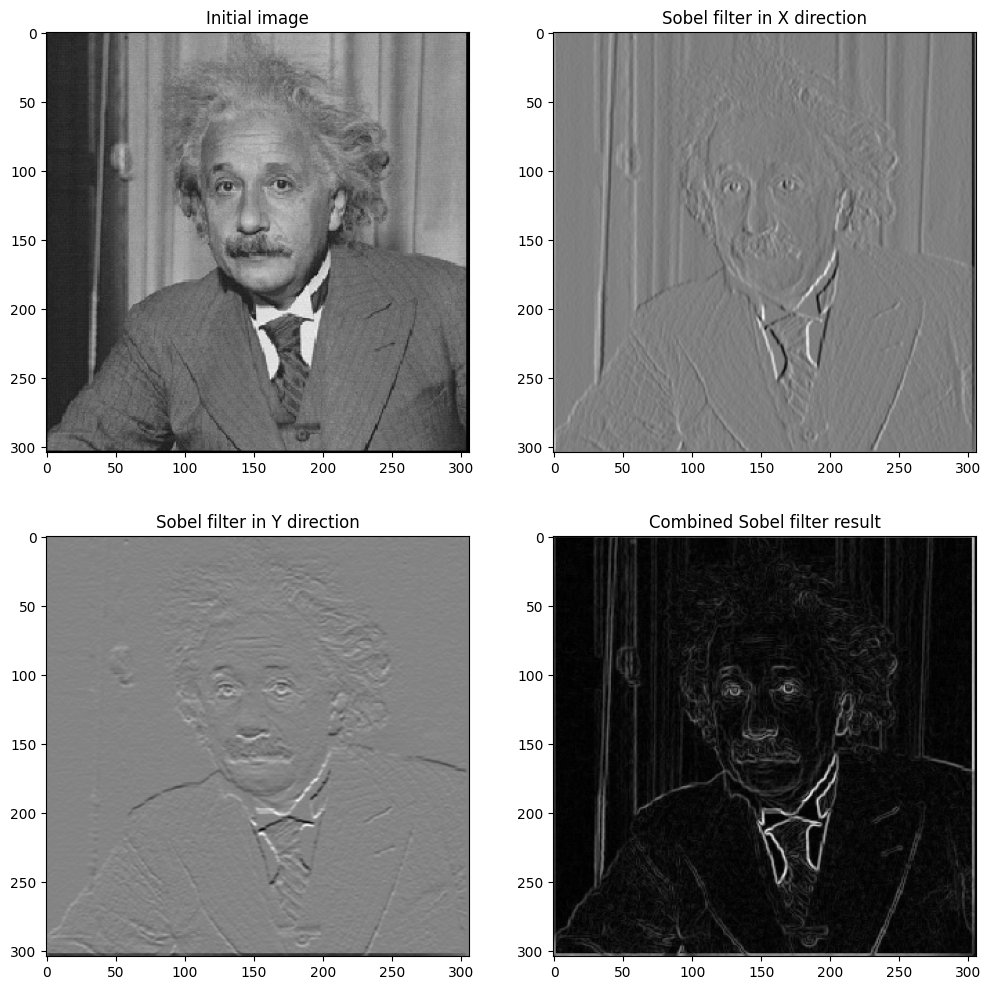

In [47]:
img = cv2.imread("../dataset/einstein.png")
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(np.float32)
sobel_x = sobel_filter(img_gray, 1, 0, ksize=3)  # Sobel filter in x direction
sobel_y = sobel_filter(img_gray, 0, 1, ksize=3)  # Sobel filter in y direction
sobel_combined = sobel_filter(img_gray,1,1,ksize=3)  # Combine the gradients
fig = plt.figure(figsize=(12, 12))
ax1 = plt.subplot(2, 2, 1)
ax1.title.set_text("Initial image")
plt.imshow(img_gray, "gray")
ax2 = plt.subplot(2, 2, 2)
ax2.title.set_text("Sobel filter in X direction")
plt.imshow(sobel_x, "gray")
ax3 = plt.subplot(2, 2, 3)
ax3.title.set_text("Sobel filter in Y direction")
plt.imshow(sobel_y, "gray")
ax4 = plt.subplot(2, 2, 4)
ax4.title.set_text("Combined Sobel filter result")
plt.imshow(sobel_combined, "gray")
plt.show()

# Part 3: Corner Detection

In the second lecture of the week we went through about corner detection algorithms and how these can be used to find
interesting features on an image that can be used in applications such as stereo matching,
3D reconstruction, tracking, localization and recognition.
Our task here is to code two corner detection algorithms, the Moravec and the Harris
corner detector.

In [ ]:
import numpy as np
import copy
import cv2
from matplotlib import pyplot as plt
import random
from PIL import Image
#to visualize the plots within the notebook
%matplotlib inline
# for making plots looking nicer
plt.style.use('fivethirtyeight')

## Task 6: Moravec corner detector

The Moravec corner detector uses a patch centred on each pixel as its own matching
template. The patch is shifted so that it is centred on each of the 8 neighbours of the pixel
and the sum of squared differences (SSD) is calculated between the original patch and the
shifted patch:

$$
    E = \sum_{\Delta \mathbf{x}} w(\Delta \mathbf{x})\big(I(\mathbf{x} + \Delta \mathbf{x}) - I(\mathbf{x}^{\prime} + \Delta \mathbf{x}\big)^2
$$


$w$ is a weighting function with the same dimension as the patch, you can use a Gaussian or constant weights. The corner metric (cornerness) is then taken to be the minimum of the SSD values calculated for each of the eight shifts of the window.
A pixel is marked as a corner if its cornerness is above a user-specified threshold.


Your task is to write your implementation of the Moravec corner detector.
It will take as input a grayscale image, the window size, the threshold and optionally a Gaussian function for $w$. It will give as output a corner map as a list of pixel coordinates where a corner is detected.


In [17]:
def draw_corners(image, corners_map, color=(255, 0, 0)):
    """Draw a point for each possible corner.
    color image: [H, W, 3]
    corners_map: list of pixel coordinates (xy indexing)
    """
    
    color_img = cv2.cvtColor(image[:,:,0], cv2.COLOR_GRAY2BGR)
    for corner in corners_map:
        cv2.circle(color_img, corner, 1, color, -1)
    return color_img

def make_mean_filter_kernel(h, w):
    return np.ones((h, w)) / (h * w)

def make_gaussian_kernel(h, w, sigma):
    assert (h % 2 == 1) and (w % 2 == 1), print("kernal size must be odd number!")
    
    x = np.arange(-(h // 2), h // 2 + 1, 1.)
    y = np.arange(-(w // 2), w // 2 + 1, 1.)
    xx, yy = np.meshgrid(x, y)
    two_sigma_2 = 2 * sigma ** 2
    G = np.exp(-(xx ** 2 + yy ** 2) / two_sigma_2) / (two_sigma_2 * np.pi)
    G /= G.sum()
    return G

def SSD(patch1, patch2, weight):
    return (weight * (patch1 - patch2) ** 2).sum()

def moravec(image, window_size=3, threshold=100., weights=None):
    """Moravec's corner detection for each pixel of the image.
    image: grayscale image: [H, W]
    """
    assert window_size % 2 == 1, "window size should be an odd number"
    
    neighbours = [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (-1, 1), (1, -1), (1, 1)]
    if weights is None:
        weights = make_mean_filter_kernel(window_size, window_size)
    
    corners = []
    k = window_size // 2
    H, W = image.shape[0], image.shape[1]
    for i in range(0, H):
        for j in range(0, W):
            if i-k < 0 or j-k < 0 or i+k >= H or j+k >= W:
                continue
            centre_patch = image[i-k:i+k+1, j-k:j+k+1]
            E = []
            for nei in neighbours:
                di, dj = nei
                ii, jj = i + di, j + dj
                if ii-k < 0 or jj-k < 0 or ii+k >= H or jj+k >= W:
                    continue
                patch = image[ii-k:ii+k+1, jj-k:jj+k+1]
                E.append(SSD(centre_patch, patch, weights))
            minE = np.array(E).min()
            if minE > threshold:
                corners.append((j, i))

    return corners

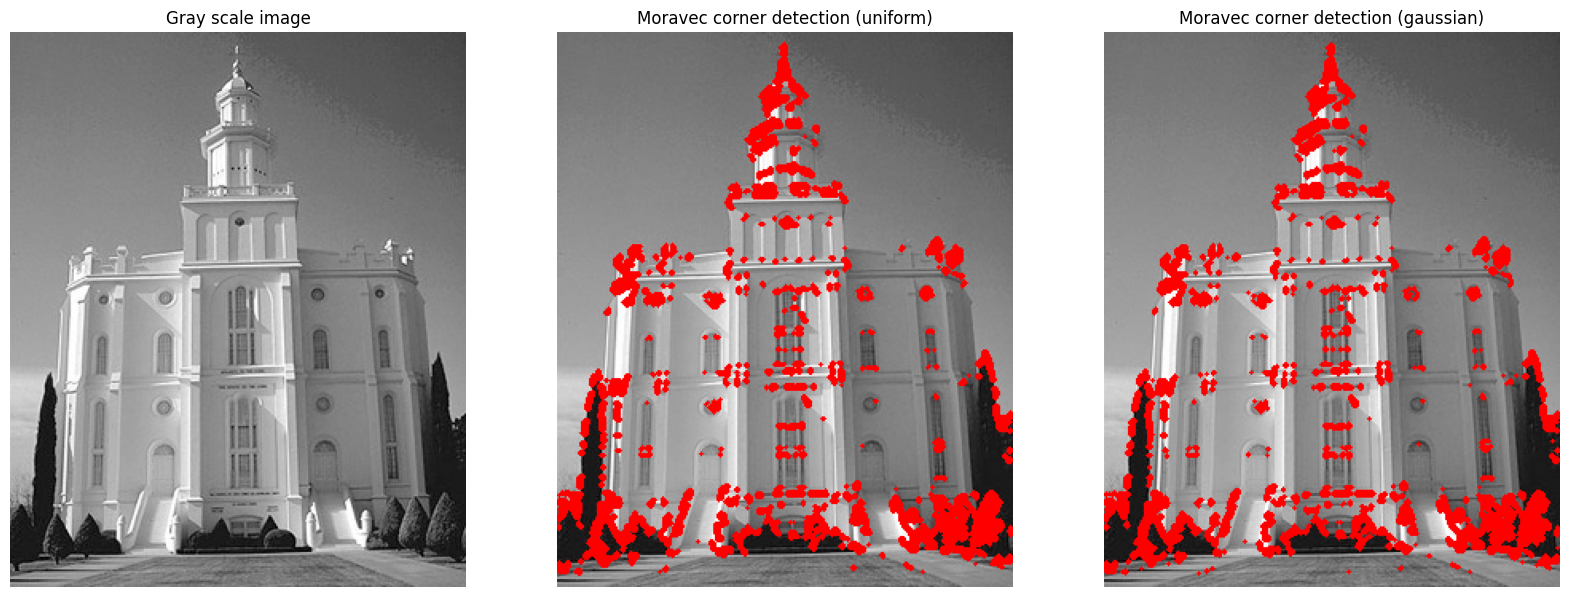

In [ ]:
img = cv2.imread('../dataset/building.png')
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(np.float32)

moravec_corners = moravec(gray_img, threshold=200.)
img_with_corner = draw_corners(img, moravec_corners)

moravec_corners2 = moravec(gray_img, threshold=200., weights=make_gaussian_kernel(3, 3, 1.0))
img_with_corner2 = draw_corners(img, moravec_corners2)

# Show Original and detected corners on image
fig, axis = plt.subplots(1, 3, figsize=(20, 8), sharey=False)
axis[0].imshow(gray_img, 'gray')
axis[0].grid(False)
axis[0].set_title('Gray scale image')
axis[0].set_axis_off()

axis[1].imshow(img_with_corner, 'gray')
axis[1].grid(False)
axis[1].set_title('Moravec corner detection (uniform)')
axis[1].set_axis_off()

axis[2].imshow(img_with_corner2, 'gray')
axis[2].grid(False)
axis[2].set_title('Moravec corner detection (gaussian)')
axis[2].set_axis_off()

plt.show()

## Task 7: Harris corner detector

The Harris corner detector builds upon the concepts of the Moravec corner detector, but
overcomes its limitations by generalising the measure of cornerness.
The basic limitation of the Moravec detector is that it only calculates cornerness for the 8 main directions
corresponding to the neighbours of a pixel, which means it will not detect a corner in any other direction.
The Harris detector uses the image structure tensor to overcome this. The image structure tensor is:

$$
    S = 
    \begin{pmatrix}
     I^2_x   & I_x I_y\\
     I_x I_y & I^2_y
    \end{pmatrix}
$$

where $I_x$ is the partial derivative of the image in the x direction and $I_y$ is the partial derivative of the image in the y direction.
The structure tensor summarizes the main directions of the gradient of the image for every pixel and therefore its two eigenvalues can be used to determine whether there is a corner at a pixel (if both eigenvalues are large).
The cornerness response metric is then defined as follows:

$$
    C = \text{det}(S) - k \text{tr}(S)^2 \\
$$

where $k$ is a an empirically determined hyper-parameter, usually in the range of $[0.04, 0.06]$

### Non-maximum Suppression (NMS)

In most cases, naivly thresholding the response map will lead to a lot of false-positives, i.e. blobs around real corners. One way to mitigate this to use Non-maximum Suppression (NMS). There is a number of ways of doing it, but the principle is to only keep the pixel with maxium response for aby local regions. You can try by simply setting pixels that have an 8 neighbour with higher cornerness to zero.

In [ ]:
"""
Utility functions here, you can use code from the last week. FFT implementation is reccomended as it is faster.
"""
def apply_filter(src_img, kernel):
    pass


def apply_gaussian_filter(src_img, k=5, sigma=1.0):
    pass


def gradientX(image):
    kernel = np.array([[-1., 0., 1.],
                       [-2., 0., 2.],
                       [-1., 0., 1.]]) / 9.
    filtered_image = apply_filter(image, kernel)
    return filtered_image

def gradientY(image):
    kernel = np.array([[-1., -2., -1.],
                       [0., 0., 0.],
                       [1., 2., 1.]]) / 9.
    filtered_image = apply_filter(image, kernel)
    return filtered_image


def nms(response, threshold, window_size=3):
    pass

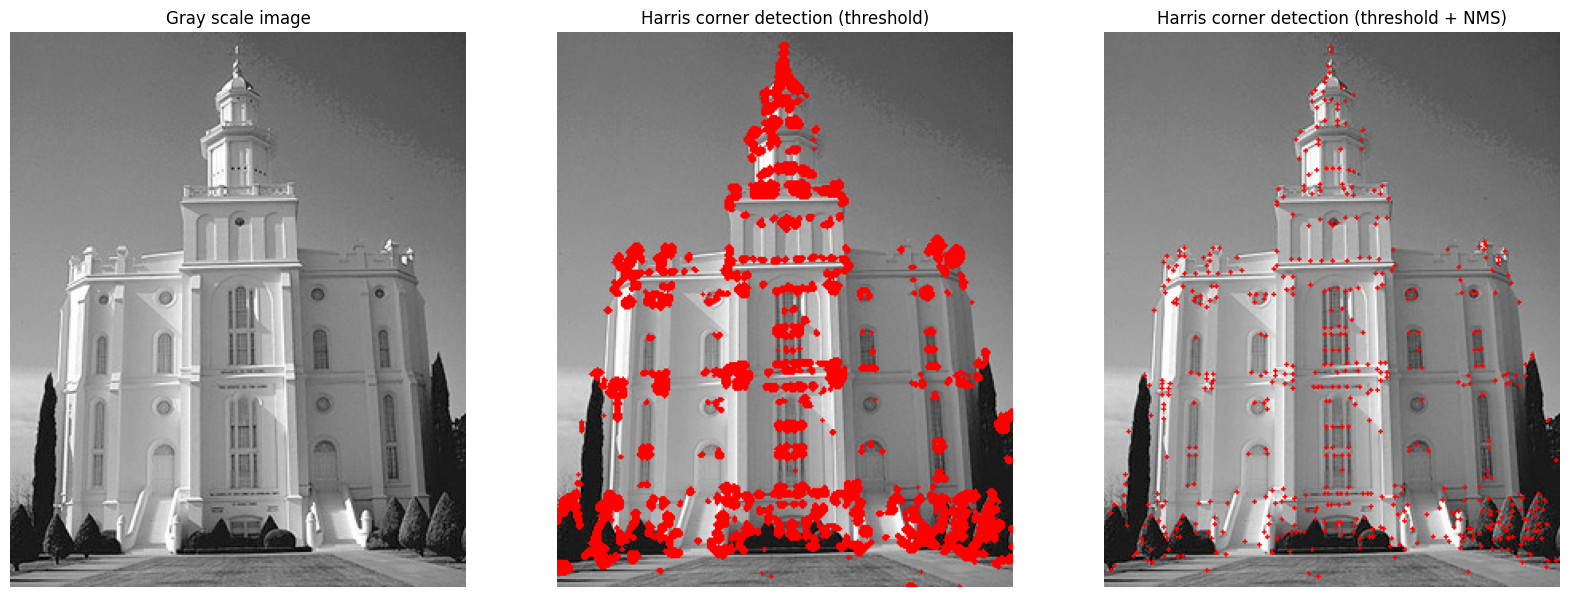

In [ ]:
img = cv2.imread('../dataset/building.png')
k = 0.05
threshold = 2000.
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(np.float32)
H, W = gray_img.shape
# Write your code here:

corners =
harris_img_corner = draw_corners(img, corners)
# corners after NMS
corners_nms =
harris_img_corner_nms = draw_corners(img, corners_nms)

# Show Original and detected corners on image
fig, axis = plt.subplots(1, 3, figsize=(20, 8), sharey=False)
axis[0].imshow(gray_img, 'gray')
axis[0].grid(False)
axis[0].set_title('Gray scale image')
axis[0].set_axis_off()

axis[1].imshow(harris_img_corner, 'gray')
axis[1].grid(False)
axis[1].set_title('Harris corner detection (threshold)')
axis[1].set_axis_off()

axis[2].imshow(harris_img_corner_nms, 'gray')
axis[2].grid(False)
axis[2].set_title('Harris corner detection (threshold + NMS)')
axis[2].set_axis_off()

plt.show()

# Part 4 Feature extraction and Matching


## Task 8 SIFT Feature Detection and Matching

#### Step 1: SIFT Feature Detection and Visualization
Here we demonstrates how SIFT detects features in a single image:
- Loads and preprocesses the image
- Detects SIFT keypoints
- Visualizes the keypoints on the image
- Shows keypoint orientations and scales

#### Step 2: Feature Matching Between Images
Here we show how SIFT features are matched between two images:
- Detects features in both images
- Matches features using ratio test
- Visualizes the matching results with lines connecting matched points
- Shows match distance distribution

### Tasks:

1. With the example provided:
   1.  Vary the paratmeter on  'max_image_size', 'max_features', 'ratio_thresh' to see their impact on perforamnce, such as matching reuslt and time consumption.

2. Capture your own image pair with:
   1. Slight variation of angle and match them
   2. Big variation of angle and match them
   3. Different time of the day or lighting variation and match them
   4. With one image using your phone or laptop webcam and match them

3. Compare Harris detector result with SIFT and FAST (https://docs.opencv.org/3.4/df/d0c/tutorial_py_fast.html)


In [ ]:
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt

#### Common Functions

In [ ]:
# Common Functions
def load_image(image_path, max_size):
    """Load and resize image if too large"""
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Could not load image: {image_path}")
    
    # Resize if image is too large
    h, w = img.shape[:2]
    if max(h, w) > max_size:
        scale = max_size / max(h, w)
        new_size = (int(w * scale), int(h * scale))
        img = cv2.resize(img, new_size, interpolation=cv2.INTER_AREA)
    
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    return img_gray, img_rgb

def visualize_features(img_rgb, keypoints, title="SIFT Features"):
    """Visualize SIFT features with circles and orientations"""
    img_with_kp = img_rgb.copy()
    
    for kp in keypoints:
        x, y = int(kp.pt[0]), int(kp.pt[1])
        size = int(kp.size)
        angle = kp.angle * np.pi / 180.0
        
        cv2.circle(img_with_kp, (x, y), size, (0, 255, 0), 1)
        end_x = int(x + size * np.cos(angle))
        end_y = int(y + size * np.sin(angle))
        cv2.line(img_with_kp, (x, y), (end_x, end_y), (0, 255, 0), 1)
    
    plt.figure(figsize=(12, 8))
    plt.imshow(img_with_kp)
    plt.title(f"{title}\n{len(keypoints)} keypoints detected")
    plt.axis('off')
    plt.tight_layout()

    
def visualize_matches(img1_rgb, img2_rgb, keypoints1, keypoints2, good_matches, 
                     distances, max_display_matches):
    """Visualize feature matches between images"""
    good_matches = sorted(good_matches, key=lambda x: x.distance)[:max_display_matches]
    
    plt.figure(figsize=(12, 6))
    
    # Plot histogram
    plt.subplot(1, 2, 1)
    plt.hist(distances, bins=30, color='blue', alpha=0.7)
    plt.title(f"Match Distances\n({len(good_matches)} shown of {len(distances)} matches)")
    plt.xlabel("Distance")
    plt.ylabel("Count")
    
    # Draw matches
    match_img = cv2.drawMatches(
        img1_rgb, keypoints1,
        img2_rgb, keypoints2,
        good_matches, None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
        matchColor=(0, 255, 0)
    )
    
    plt.subplot(1, 2, 2)
    plt.imshow(match_img)
    plt.title("SIFT Matches")
    plt.axis('off')
    plt.tight_layout()


In [ ]:
def detect_features(img, max_features):
    """Detect SIFT features"""
    sift = cv2.SIFT_create(nfeatures=max_features)
    keypoints, descriptors = sift.detectAndCompute(img, None)
    return keypoints, descriptors


In [ ]:
def match_features(descriptors1, descriptors2, ratio_thresh):
    """Match features using BFMatcher with ratio test"""
    bf = cv2.BFMatcher(cv2.NORM_L2)
    matches = bf.knnMatch(descriptors1, descriptors2, k=2)
    
    good_matches = []
    distances = []
    for m, n in matches:
        if m.distance < ratio_thresh * n.distance:
            good_matches.append(m)
            distances.append(m.distance)
    
    return good_matches, distances

#### Extract Feature Points


=== Stage 1: Single Image SIFT Detection ===
Image size: (554, 800, 3)
Processing time: 0.232 seconds
Features detected: 1000


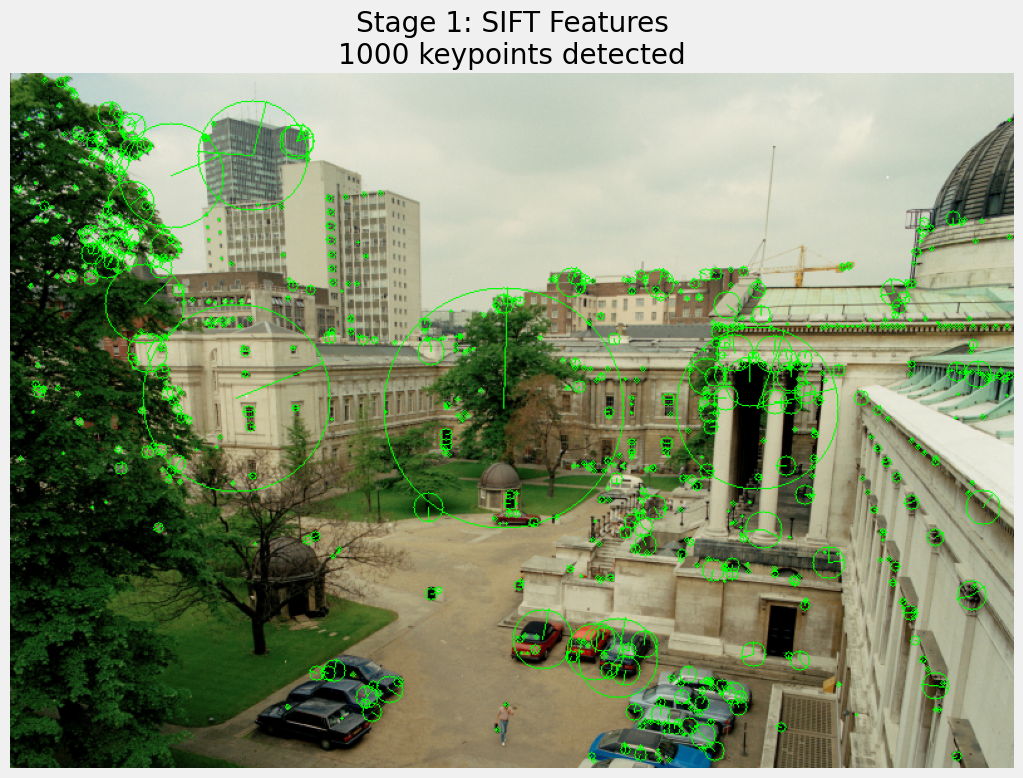

In [ ]:
# Parameters for Stage 1
params = {
    'max_image_size': 800,
    'max_features': 1000,
}

# Image path
img_path = '../dataset/UCL_21May91.jpg'

print("\n=== Stage 1: Single Image SIFT Detection ===")

# Load and process image
t0 = time.time()
img_gray, img_rgb = load_image(img_path, params['max_image_size'])
print(f"Image size: {img_rgb.shape}")

# Detect features
keypoints, descriptors = detect_features(img_gray, params['max_features'])
t1 = time.time()

print(f"Processing time: {t1-t0:.3f} seconds")
print(f"Features detected: {len(keypoints)}")

# Visualize
visualize_features(img_rgb, keypoints, "Stage 1: SIFT Features")
plt.show()

#### Match feature Points 


=== Stage 2: Feature Matching ===
Image 1 features: 1000
Image 2 features: 1001
Processing time: 0.543 seconds
Matches found: 104 good matches


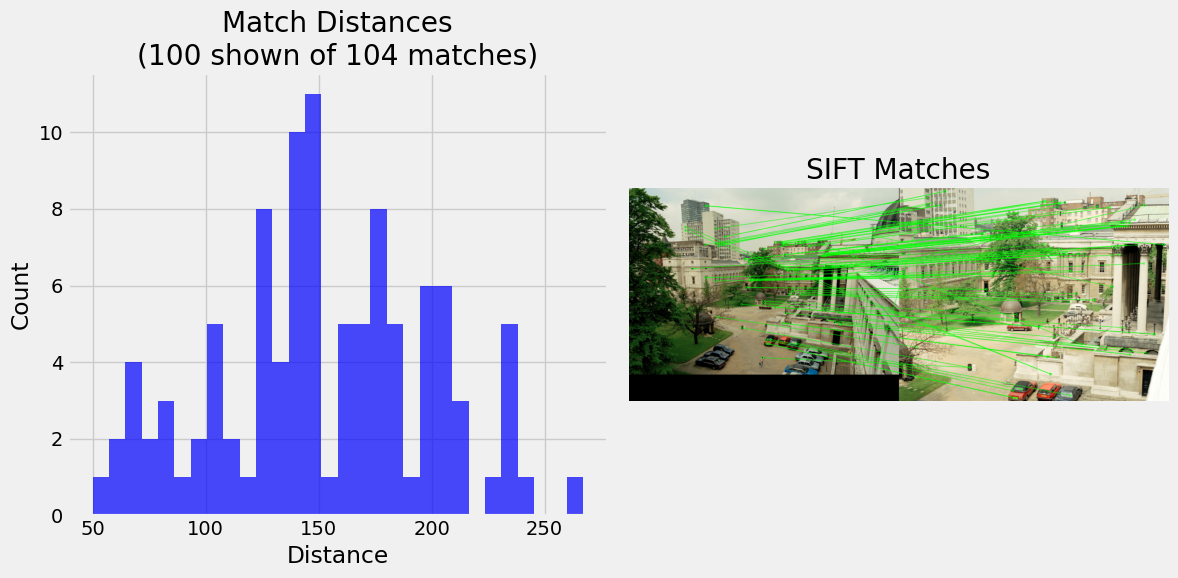

In [ ]:
# Parameters for Stage 2
params = {
    'max_image_size': 800,
    'max_features': 1000,
    'ratio_thresh': 0.75,
    'max_display_matches': 100
}
# Image paths
img1_path = '../dataset/UCL_21May91.jpg'
img2_path = '../dataset/UCLQuad_21May91.jpg'

print("\n=== Stage 2: Feature Matching ===")

# Load and process first image
t0 = time.time()
img1_gray, img1_rgb = load_image(img1_path, params['max_image_size'])
keypoints1, descriptors1 = detect_features(img1_gray, params['max_features'])
print(f"Image 1 features: {len(keypoints1)}")

# Load and process second image
img2_gray, img2_rgb = load_image(img2_path, params['max_image_size'])
keypoints2, descriptors2 = detect_features(img2_gray, params['max_features'])
print(f"Image 2 features: {len(keypoints2)}")

# Match features
good_matches, distances = match_features(descriptors1, descriptors2, 
                                       params['ratio_thresh'])
t1 = time.time()

print(f"Processing time: {t1-t0:.3f} seconds")
print(f"Matches found: {len(good_matches)} good matches")

# Visualize matches
visualize_matches(img1_rgb, img2_rgb, keypoints1, keypoints2, 
                good_matches, distances, params['max_display_matches'])
plt.show()